<a href="https://colab.research.google.com/github/samiha-mahin/An-Image-Processing-Repo/blob/main/ViT_Flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"3b6d29c9556db74812f31ee98a90662f"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download alsaniipe/flowers-dataset -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/alsaniipe/flowers-dataset
License(s): CC0-1.0
  0% 0.00/60.5M [00:00<?, ?B/s]
100% 60.5M/60.5M [00:00<00:00, 1.11GB/s]


In [5]:
train_dir = "/content/data/train"

/tmp/ipython-input-2751832124.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="label", y="count", data=df, palette=custom_colors)
/tmp/ipython-input-2751832124.py:15: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(x="label", y="count", data=df, palette=custom_colors)


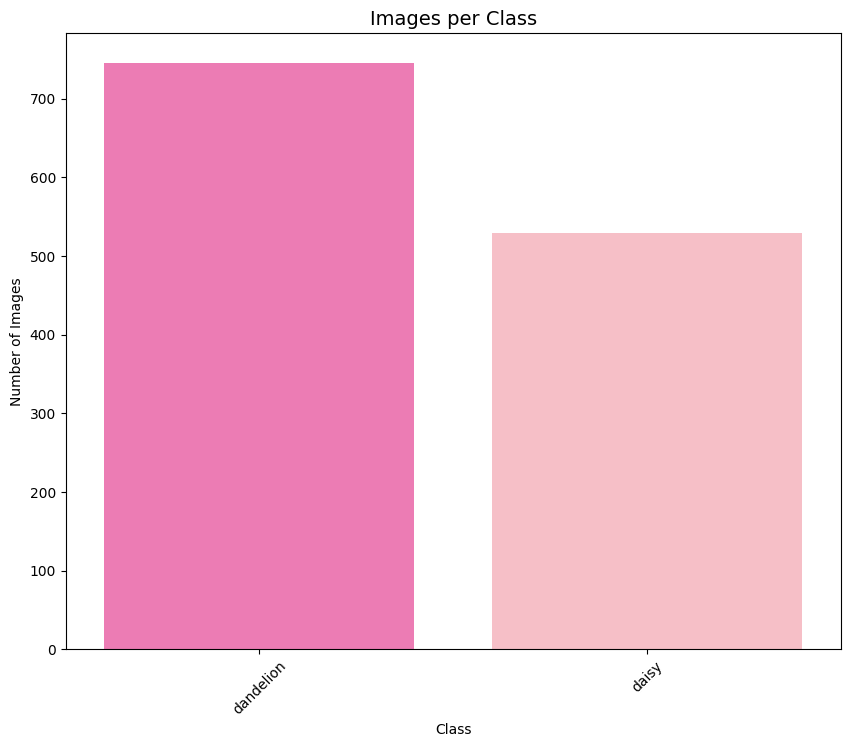

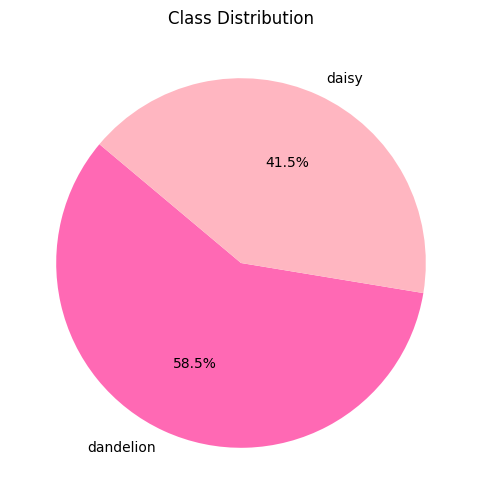

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.DataFrame([(cls, len(os.listdir(os.path.join(train_dir, cls))))
                   for cls in os.listdir(train_dir)], columns=["label", "count"])


custom_colors = ["#FF69B4", "#FFB6C1", "#FF1493", "#FFC0CB", "#DB7093"]

# Bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x="label", y="count", data=df, palette=custom_colors)
plt.xticks(rotation=45)
plt.title("Images per Class", fontsize=14)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Pie chart
df.set_index("label")["count"].plot(kind="pie", autopct="%1.1f%%",
                                    startangle=140, figsize=(6,6),
                                    colors=custom_colors)
plt.title("Class Distribution")
plt.ylabel("")
plt.show()


In [25]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import os

#Encoding the labels into the numbers
encoder = LabelEncoder()
df["Label_num"] = encoder.fit_transform(df["label"])

# Create a list of image paths and their corresponding labels
image_paths = []
labels_num = []
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_path):
        image_paths.append(os.path.join(cls_path, img_name))
        labels_num.append(encoder.transform([cls])[0])

# Create a DataFrame with image paths and numerical labels
image_df = pd.DataFrame({"image_path": image_paths, "label_num": labels_num})

#Oversample to balance classes
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(image_df[["image_path"]], image_df["label_num"])

#Creating the new balanced dataFrame
df_balanced = pd.DataFrame({"image_path":X["image_path"] , "label_num":y})

print("\nBalanced class counts:")
print(df_balanced["label_num"].value_counts())


Balanced class counts:
label_num
1    746
0    746
Name: count, dtype: int64


In [30]:
import random
import numpy as np

# Reproducibility
def set_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



In [31]:
# Convert label_num back to integer for convenience
df_balanced['label_num'] = df_balanced['label_num'].astype(str)

# Function to sample fixed number of images per class
def sample_per_class(df, n):
    return df.groupby('label_num').sample(n=n, random_state=42)

# Sample 300 images per class for training
train_df = sample_per_class(df_balanced, 300)

# Remove training samples from df_balanced to avoid overlap
remaining_df = df_balanced.drop(train_df.index)

# Sample 100 images per class for validation
valid_df = sample_per_class(remaining_df, 100)

# Remove validation samples to get test set
remaining_df = remaining_df.drop(valid_df.index)

# Sample 100 images per class for testing
test_df = sample_per_class(remaining_df, 100)

# Check new sizes
print("Train size:", train_df.shape)
print("Validation size:", valid_df.shape)
print("Test size:", test_df.shape)

# Optional: check class distribution
print(train_df['label_num'].value_counts())
print(valid_df['label_num'].value_counts())
print(test_df['label_num'].value_counts())

Train size: (600, 2)
Validation size: (200, 2)
Test size: (200, 2)
label_num
0    300
1    300
Name: count, dtype: int64
label_num
0    100
1    100
Name: count, dtype: int64
label_num
0    100
1    100
Name: count, dtype: int64


In [32]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


In [33]:
class FlowersDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        label = int(self.df.iloc[idx]["label_num"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [34]:
import torchvision

# Get pretrained ViT-B/16 weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Automatic transforms for ViT
pretrained_vit_transforms = pretrained_vit_weights.transforms()

# Optional: check transform
print(pretrained_vit_transforms)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [35]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

# Create datasets
train_dataset = FlowersDataset(train_df, transform=pretrained_vit_transforms)
valid_dataset = FlowersDataset(valid_df, transform=pretrained_vit_transforms)
test_dataset  = FlowersDataset(test_df, transform=pretrained_vit_transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


In [36]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained ViT-B/16
vit_model = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze base parameters
for param in vit_model.parameters():
    param.requires_grad = False

# Change classifier head
num_classes = len(df_balanced['label_num'].unique())
vit_model.heads = nn.Linear(in_features=768, out_features=num_classes).to(device)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:06<00:00, 54.1MB/s]


In [37]:
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()


In [38]:
def train_model(model, train_loader, valid_loader, loss_fn, optimizer, epochs, device):
    history = {"train_loss": [], "valid_loss": []}

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for imgs, labels in valid_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)
                valid_loss += loss.item() * imgs.size(0)
        valid_loss /= len(valid_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")
        history["train_loss"].append(train_loss)
        history["valid_loss"].append(valid_loss)

    return history


In [ ]:
set_seeds()
history = train_model(
    model=vit_model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5,
    device=device
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["valid_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

vit_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = vit_model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get class names
class_names = [str(i) for i in range(num_classes)]  # or encoder.classes_ if you want original labels

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(12,12))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix - Test Set")
plt.show()
